In [3]:
import pandas as pd
import numpy as np
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Layer
import tensorflow as tf

# Download necessary NLTK resources
nltk.download('punkt')

# Step 1: Read CSV file into DataFrame
file_path = '/content/final.csv'  # Adjust path as needed
df = pd.read_csv(file_path)

# Tokenizer setup
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df['caption'])
vocab_size = len(tokenizer.word_index) + 1

# Convert captions to sequences
X = tokenizer.texts_to_sequences(df['caption'])
max_length = max(len(seq) for seq in X)  # Determine the maximum sequence length
X = pad_sequences(X, maxlen=max_length, padding='post')

# Prepare labels
label_mapping = {label: idx for idx, label in enumerate(df['category'].unique())}
df['label'] = df['category'].map(label_mapping)
y = to_categorical(df['label'], num_classes=len(label_mapping))

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Dropout, LayerNormalization, MultiHeadAttention
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [
                Dense(ff_dim, activation="relu"),  # Feed-forward network
                Dense(embed_dim),
            ]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        # Self-attention with normalization and dropout
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        # Feed-forward network with normalization and dropout
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Embedding and positional encoding
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [5]:
# Hyperparameters
embed_dim = 128  # Embedding size for each token
num_heads = 4    # Number of attention heads
ff_dim = 128     # Hidden layer size in feed-forward network

# Build the Transformer model
inputs = Input(shape=(max_length,))
embedding_layer = TokenAndPositionEmbedding(max_length, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x, training=True)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
outputs = Dense(len(label_mapping), activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])



In [6]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 29s 168ms/step - accuracy: 0.3559 - loss: 1.2742 - val_accuracy: 0.3954 - val_loss: 1.0940
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.3359 - loss: 1.1021 - val_accuracy: 0.2985 - val_loss: 1.1059
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.3691 - loss: 1.0958 - val_accuracy: 0.3954 - val_loss: 1.0919
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.3671 - loss: 1.0844 - val_accuracy: 0.3061 - val_loss: 1.0914
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.3763 - loss: 1.0850 - val_accuracy: 0.3163 - val_loss: 1.0755
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.3821 - loss: 1.0764 - val_accuracy: 0.3265 - val_loss: 1.0857
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.4253 - loss: 1.0644 - val_accuracy: 0.3112 - val_loss: 1.0884
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.4022 - loss: 1.0612 - val_accuracy

In [10]:
# Evaluate the model
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {val_accuracy * 100:.2f}%")

Final Training Accuracy: 92.09%
Final Validation Accuracy: 91.84%


In [11]:
# Save the model
model.save('transformer_text_classifier.h5')

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9126 - loss: 0.3068
Validation Accuracy: 91.84%
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step


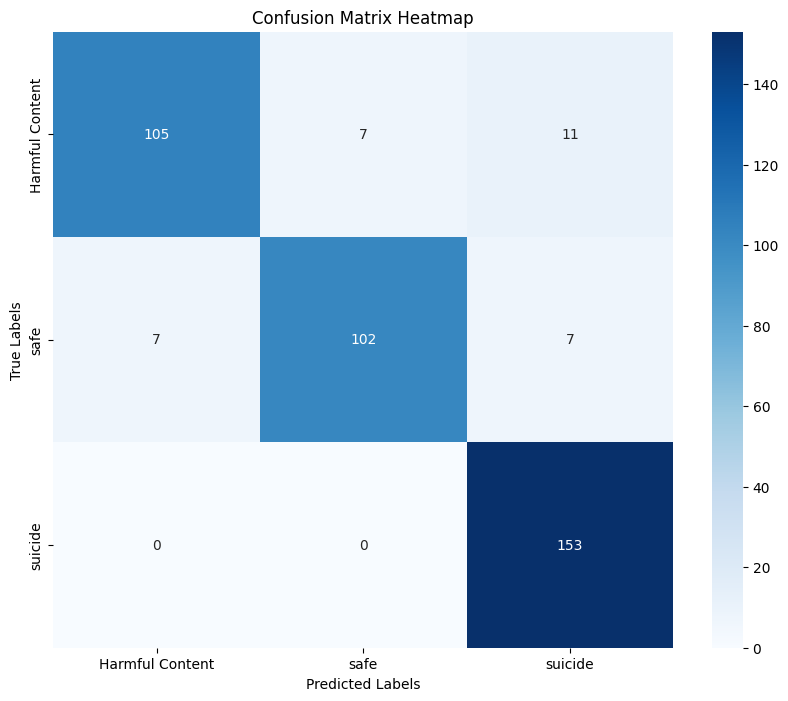

Classification Report:
                 precision    recall  f1-score   support

Harmful Content       0.94      0.85      0.89       123
           safe       0.94      0.88      0.91       116
        suicide       0.89      1.00      0.94       153

       accuracy                           0.92       392
      macro avg       0.92      0.91      0.91       392
   weighted avg       0.92      0.92      0.92       392



In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Calculate Validation Accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Step 2: Generate Predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted labels
y_true = np.argmax(y_val, axis=1)  # True labels

# Step 3: Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
cm_labels = [label for label, _ in sorted(label_mapping.items(), key=lambda x: x[1])]

# Step 4: Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=cm_labels, yticklabels=cm_labels)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Step 5: Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=cm_labels))


In [9]:
# Prediction function
def predict_caption(caption):
    sequence = tokenizer.texts_to_sequences([caption])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
    prediction = model.predict(padded_sequence)
    predicted_label_index = np.argmax(prediction)
    predicted_label = {v: k for k, v in label_mapping.items()}[predicted_label_index]
    confidence = prediction[0][predicted_label_index] * 100
    print(f"Caption: {caption}")
    print(f"Predicted Category: {predicted_label} ({confidence:.2f}% confidence)")

# Example usage
caption_input = "girl wearing a skirt and sharing donuts with her friends"
predict_caption(caption_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
Caption: girl wearing a skirt and sharing donuts with her friends
Predicted Category: safe (95.00% confidence)
